# vanishing gradient

## sigmoid - gauss

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.1
                : 10. 正答率(テスト) = 0.098
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.1028
Generation: 30. 正答率(トレーニング) = 0.13
                : 30. 正答率(テスト) = 0.1028
Generation: 40. 正答率(トレーニング) = 0.12
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.03
                : 50. 正答率(テスト) = 0.101
Generation: 60. 正答率(トレーニング) = 0.09
                : 60. 正答率(テスト) = 0.101
Generation: 70. 正答率(トレーニング) = 0.13
                : 70. 正答率(テスト) = 0.101
Generation: 80. 正答率(トレーニング) = 0.1
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.05
                : 90. 正答率(テスト) = 0.1009
Generation: 100. 正答率(トレーニング) = 0.07
                : 100. 正答率(テスト) = 0.0982
Generation: 110. 正答率(トレーニング) = 0.06
                : 110. 正答率(テスト) = 0.0958
Generation: 120. 正答率(トレーニング) = 0.09
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.13
                : 130. 正答率(テスト) = 0.1135
Generation: 1

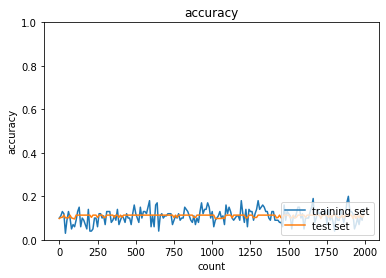

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20
hidden_layer_3_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_1_size)
    network['W2'] = wieght_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
    network['W3'] = wieght_init * np.random.randn(hidden_layer_2_size, hidden_layer_3_size)
    network['W4'] = wieght_init * np.random.randn(hidden_layer_3_size, output_layer_size)

    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(hidden_layer_3_size)
    network['b4'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_f = functions.sigmoid
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    z3 = hidden_f(u3)
    u4 =  np.dot(z3, W4) + b4
    y = functions.softmax(u4)
 
    return z1, z2, z3, y

# 誤差逆伝播
def backward(x, d, z1, z2, z3, y):
    grad = {}
    
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_d_f = functions.d_sigmoid
    last_d_f = functions.d_softmax_with_loss
    
    
    # 出力層でのデルタ
    delta4 = last_d_f(d, y)
   # b4の勾配
    grad['b4'] = np.sum(delta4, axis=0)
    # W4の勾配
    grad['W4'] = np.dot(z3.T, delta4)
    # 3層でのデルタ
    delta3 = np.dot(delta4, W4.T) * hidden_d_f(z3)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, z3, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, z2, z3, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, z3, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'W4', 'b1', 'b2', 'b3', 'b4'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## ReLU - gauss

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.06
                : 10. 正答率(テスト) = 0.1135
Generation: 20. 正答率(トレーニング) = 0.19
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.09
                : 30. 正答率(テスト) = 0.1135
Generation: 40. 正答率(トレーニング) = 0.11
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.11
                : 50. 正答率(テスト) = 0.1135
Generation: 60. 正答率(トレーニング) = 0.12
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.15
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.08
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.13
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.08
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.15
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.11
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.13
                : 130. 正答率(テスト) = 0.1135
Generat

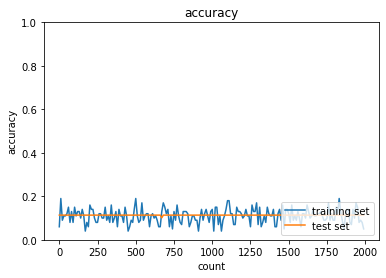

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from data.mnist import load_mnist
from PIL import Image
import pickle
from common import functions
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20
hidden_layer_3_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_1_size)
    network['W2'] = wieght_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
    network['W3'] = wieght_init * np.random.randn(hidden_layer_2_size, hidden_layer_3_size)
    network['W4'] = wieght_init * np.random.randn(hidden_layer_3_size, output_layer_size)

    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(hidden_layer_3_size)
    network['b4'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_f = functions.relu
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    z3 = hidden_f(u3)
    u4 =  np.dot(z3, W4) + b4
    y = functions.softmax(u4)
 
    return z1, z2, z3, y

# 誤差逆伝播
def backward(x, d, z1, z2, z3, y):
    grad = {}
    
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_d_f = functions.d_relu
    last_d_f = functions.d_softmax_with_loss
    
    
    # 出力層でのデルタ
    delta4 = last_d_f(d, y)
   # b4の勾配
    grad['b4'] = np.sum(delta4, axis=0)
    # W4の勾配
    grad['W4'] = np.dot(z3.T, delta4)
    # 3層でのデルタ
    delta3 = np.dot(delta4, W4.T) * hidden_d_f(z3)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, z3, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, z2, z3, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, z3, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'W4', 'b1', 'b2', 'b3', 'b4'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


## sigmoid - Xavier

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.12
                : 10. 正答率(テスト) = 0.1028
Generation: 20. 正答率(トレーニング) = 0.16
                : 20. 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.15
                : 30. 正答率(テスト) = 0.1305
Generation: 40. 正答率(トレーニング) = 0.14
                : 40. 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.11
                : 50. 正答率(テスト) = 0.1032
Generation: 60. 正答率(トレーニング) = 0.1
                : 60. 正答率(テスト) = 0.0958
Generation: 70. 正答率(トレーニング) = 0.1
                : 70. 正答率(テスト) = 0.0958
Generation: 80. 正答率(トレーニング) = 0.13
                : 80. 正答率(テスト) = 0.11
Generation: 90. 正答率(トレーニング) = 0.11
                : 90. 正答率(テスト) = 0.1028
Generation: 100. 正答率(トレーニング) = 0.17
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.15
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.11
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.09
                : 130. 正答率(テスト) = 0.1135
Generation:

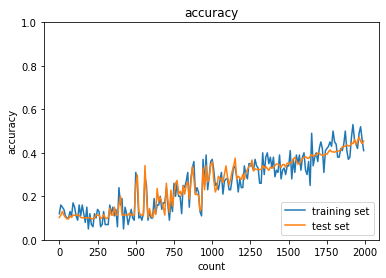

In [4]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from data.mnist import load_mnist
from PIL import Image
import pickle
from common import functions
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20
hidden_layer_3_size = 20
#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    
    ###########  変更箇所  ##############
    
    # Xavierの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / (np.sqrt(input_layer_size))
    network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / (np.sqrt(hidden_layer_1_size))
    network['W3'] = np.random.randn(hidden_layer_2_size, hidden_layer_3_size) / (np.sqrt(hidden_layer_2_size))
    network['W4'] = np.random.randn(hidden_layer_3_size, output_layer_size) / (np.sqrt(hidden_layer_3_size))
    
    #################################
    
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(hidden_layer_3_size)
    network['b4'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_f = functions.sigmoid
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    z3 = hidden_f(u3)
    u4 =  np.dot(z3, W4) + b4
    y = functions.softmax(u4)
 
    return z1, z2, z3, y

# 誤差逆伝播
def backward(x, d, z1, z2, z3, y):
    grad = {}
    
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_d_f = functions.d_sigmoid
    last_d_f = functions.d_softmax_with_loss
    
    
    # 出力層でのデルタ
    delta4 = last_d_f(d, y)
   # b4の勾配
    grad['b4'] = np.sum(delta4, axis=0)
    # W4の勾配
    grad['W4'] = np.dot(z3.T, delta4)
    # 3層でのデルタ
    delta3 = np.dot(delta4, W4.T) * hidden_d_f(z3)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, z3, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, z2, z3, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, z3, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'W4', 'b1', 'b2', 'b3', 'b4'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()


## ReLU - He

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.28
                : 10. 正答率(テスト) = 0.2482
Generation: 20. 正答率(トレーニング) = 0.25
                : 20. 正答率(テスト) = 0.2822
Generation: 30. 正答率(トレーニング) = 0.57
                : 30. 正答率(テスト) = 0.5204
Generation: 40. 正答率(トレーニング) = 0.63
                : 40. 正答率(テスト) = 0.5952
Generation: 50. 正答率(トレーニング) = 0.53
                : 50. 正答率(テスト) = 0.6841
Generation: 60. 正答率(トレーニング) = 0.82
                : 60. 正答率(テスト) = 0.7699
Generation: 70. 正答率(トレーニング) = 0.8
                : 70. 正答率(テスト) = 0.7437
Generation: 80. 正答率(トレーニング) = 0.82
                : 80. 正答率(テスト) = 0.8238
Generation: 90. 正答率(トレーニング) = 0.76
                : 90. 正答率(テスト) = 0.7845
Generation: 100. 正答率(トレーニング) = 0.88
                : 100. 正答率(テスト) = 0.8472
Generation: 110. 正答率(トレーニング) = 0.86
                : 110. 正答率(テスト) = 0.8187
Generation: 120. 正答率(トレーニング) = 0.88
                : 120. 正答率(テスト) = 0.8492
Generation: 130. 正答率(トレーニング) = 0.85
                : 130. 正答率(テスト) = 0.8438
Generati

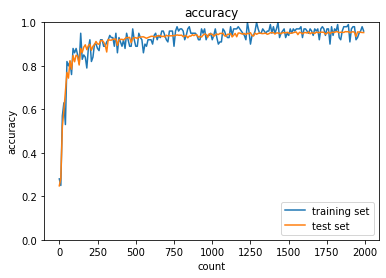

In [4]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from data.mnist import load_mnist
from PIL import Image
import pickle
from common import functions
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20
hidden_layer_3_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 

    ###########  変更箇所  ##############

    # Heの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / np.sqrt(hidden_layer_1_size) * np.sqrt(2)
    network['W3'] = np.random.randn(hidden_layer_2_size, hidden_layer_3_size) / np.sqrt(hidden_layer_2_size) * np.sqrt(2)
    network['W4'] = np.random.randn(hidden_layer_3_size, output_layer_size) / np.sqrt(hidden_layer_3_size) * np.sqrt(2)
        
    #################################
    
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(hidden_layer_3_size)
    network['b4'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_f = functions.relu
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    z3 = hidden_f(u3)
    u4 =  np.dot(z3, W4) + b4
    y = functions.softmax(u4)
 
    return z1, z2, z3, y

# 誤差逆伝播
def backward(x, d, z1, z2, z3, y):
    grad = {}
    
    W1, W2, W3, W4 = network['W1'], network['W2'], network['W3'], network['W4']
    b1, b2, b3, b4 = network['b1'], network['b2'], network['b3'], network['b4']
    hidden_d_f = functions.d_relu
    last_d_f = functions.d_softmax_with_loss
    
    
    # 出力層でのデルタ
    delta4 = last_d_f(d, y)
   # b4の勾配
    grad['b4'] = np.sum(delta4, axis=0)
    # W4の勾配
    grad['W4'] = np.dot(z3.T, delta4)
    # 3層でのデルタ
    delta3 = np.dot(delta4, W4.T) * hidden_d_f(z3)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, z3, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, z2, z3, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, z3, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'W4', 'b1', 'b2', 'b3', 'b4'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()
